In [36]:
import os
import larq as lq
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow.keras.layers import Layer
from tensorflow.python.framework import ops
from tensorflow.python.keras import initializers, regularizers, constraints
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import standard_ops

import templates

In [9]:
# Helper functions
def print_image(image):
  # Squeeze the third dimension or you can use indexing to select the first slice
  image_2d = np.squeeze(image)

  # Plotting the image
  plt.imshow(image_2d, cmap='gray')  # Use the gray colormap for grayscale
  plt.colorbar()  # Optionally add a colorbar to see the intensity scale
  plt.show()

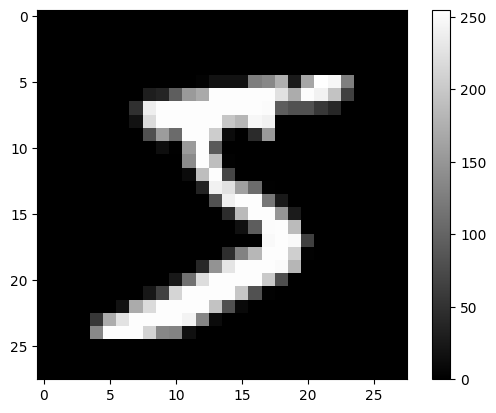

In [10]:
# Prepare dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

print_image(train_images[0])
# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

In [11]:
class InputShapeCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.input_shapes = []

    def on_epoch_end(self, epoch, logs=None):
        
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                input_shape = layer.input_shape
                self.input_shapes.append((layer.name, input_shape))
                print(f"Layer: {layer.name}, Input shape: {input_shape}")

In [12]:
# NN Topology

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

input_shape = (28, 28, 1) # Input img shape
filters_a = 32 # Number of output channels
kernel_three = (4, 4) # Kernel dimension

filters_b = 32 # Number of output channels
kernel_b = (3, 3) # Kernel dimension

model.add(lq.layers.QuantConv2D(filters_a, kernel_three,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantConv2D(filters_b, kernel_b,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())
model.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))
# model.add(tf.keras.layers.Flatten())
# # model.add(lq.layers.QuantDense(500, use_bias=False, **kwargs))
# model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
# model.add(tf.keras.layers.Activation("softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

output_shapes = [layer.output_shape for layer in model.layers]

heights = []
widths = []
channels = []

for shape in output_shapes:
    if len(shape) == 4:  
        _, height, width, channel = shape
        heights.append(height)
        widths.append(width)
        channels.append(channel)
    elif len(shape) == 2:  
        _, channel = shape
        heights.append(None)
        widths.append(None)
        channels.append(channel)

print("Heights:", heights)
print("Widths:", widths)
print("Channels:", channels)



Heights: [25, 12, 12, 10, 5, 5, None, None, None, None, None, None]
Widths: [25, 12, 12, 10, 5, 5, None, None, None, None, None, None]
Channels: [32, 32, 32, 32, 32, 32, 800, 128, 128, 10, 10, 10]


In [13]:
model.fit(train_images, train_labels, batch_size=64, epochs=6)

conv_weights = []

for layer in model.layers:
    if isinstance(layer, lq.layers.QuantConv2D):
        weights = layer.get_weights()  
        conv_weights.append(weights)


for idx, weights in enumerate(conv_weights):
    print(f"Conv layer {idx + 1} weights shape: {[w.shape for w in weights]}")

Epoch 1/6
938/938 [==============================] - 17s 17ms/step - loss: 0.6584 - accuracy: 0.9077
Epoch 2/6
938/938 [==============================] - 16s 17ms/step - loss: 0.5037 - accuracy: 0.9560
Epoch 3/6
938/938 [==============================] - 17s 18ms/step - loss: 0.4769 - accuracy: 0.9639
Epoch 4/6
938/938 [==============================] - 17s 18ms/step - loss: 0.4681 - accuracy: 0.9667
Epoch 5/6
938/938 [==============================] - 17s 18ms/step - loss: 0.4615 - accuracy: 0.9682
Epoch 6/6
938/938 [==============================] - 17s 18ms/step - loss: 0.4552 - accuracy: 0.9701
Conv layer 1 weights shape: [(4, 4, 1, 32)]
Conv layer 2 weights shape: [(3, 3, 32, 32)]


In [14]:
for idx, weights in enumerate(conv_weights):
    for w in weights:
        print(w)

[[[[-3.05359185e-01  1.22815840e-01  3.42647225e-01  1.28391501e-03
    -1.30928218e-01  4.05715294e-02 -1.87652535e-03  1.37864926e-03
     3.39959383e-01  6.48676008e-02 -4.93577728e-03  1.11516844e-03
     3.35706212e-03  4.45731133e-02 -1.95452198e-01  1.57760799e-01
    -2.93332696e-01 -7.71552995e-02 -8.45448859e-03  1.69905939e-03
    -3.53180707e-01  7.23499246e-03 -4.38118204e-02  1.31393999e-01
     5.21681039e-04  3.39547247e-01  1.96271925e-03  3.50143760e-01
    -1.07463583e-01 -3.98404838e-04 -4.60931100e-03 -9.33076080e-04]]

  [[-2.86079347e-01  2.52935648e-01 -8.98610335e-03  9.64165945e-03
     6.43169682e-04  2.02691734e-01 -1.75698008e-03  1.64705198e-02
     5.82107425e-01 -1.56878144e-03 -1.47467911e-01  8.79047886e-02
    -2.67115403e-02 -3.45480703e-02 -1.74883649e-01 -7.48347640e-02
    -8.39414299e-02 -1.30252719e-01 -1.61811396e-01  2.96775788e-01
    -1.83414738e-03 -3.94617915e-01  4.55022044e-03  1.04392104e-01
     2.80845344e-01  1.78821340e-01 -2.544118

In [15]:
QD_weights = []
for layer in model.layers:
    if isinstance(layer, lq.layers.QuantDense):
        weights = layer.get_weights()  
        QD_weights.append(weights)

binarized_weights = []
binarized_weight = [np.sign(w) for w in QD_weights]
binarized_weights.append(binarized_weight)

for w in binarized_weights:
    print(w)


[array([[[ 1., -1.,  1., ...,  1.,  1., -1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [ 1., -1., -1., ..., -1., -1., -1.],
        ...,
        [ 1.,  1., -1., ..., -1.,  1., -1.],
        [ 1.,  1.,  1., ..., -1.,  1., -1.],
        [ 1.,  1.,  1., ..., -1., -1.,  1.]]], dtype=float32), array([[[ 1.,  1.,  1., ..., -1.,  1.,  1.],
        [ 1., -1., -1., ..., -1.,  1., -1.],
        [ 1., -1., -1., ...,  1.,  1., -1.],
        ...,
        [-1., -1., -1., ...,  1.,  1., -1.],
        [-1., -1.,  1., ..., -1.,  1., -1.],
        [-1.,  1.,  1., ..., -1., -1.,  1.]]], dtype=float32)]


In [16]:
# Train NN
test_loss, test_acc = model.evaluate(test_images, test_labels)
lq.models.summary(model)

313/313 [==============================] - 2s 5ms/step - loss: 0.5302 - accuracy: 0.9654
+sequential_1 stats---------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                              (bit)                        x 1       x 1    (kB)             |
+---------------------------------------------------------------------------------------------+
| quant_conv2d_2                   1  (-1, 25, 25, 32)      512         0    0.06      320000 |
| max_pooling2d_2                  -  (-1, 12, 12, 32)        0         0       0           0 |
| batch_normalization_4            -  (-1, 12, 12, 32)        0        64    0.25           0 |
| quant_conv2d_3                   1  (-1, 10, 10, 32)     9216         0    1.12      921600 |
| max_pooling2d_3                  -    (-1, 5, 5, 32)        0         0       0           0 |
| batch_normalization_5            -    (-1, 5,

In [17]:
# # Extract weights
# with lq.context.quantized_scope(True):
#     weights = model.layers[3].get_weights()
#     print(weights)

#     if len(weights) > 0:
#         weight_array = weights[0] 
#         print("Weights shape:", weight_array.shape)
#     else:
#         print("No weights found in this layer.")

# print(weights[0].shape)
# rows, cols, _, output_channels = weights[0].shape
# print(rows, cols, output_channels)
# for col in range(cols):
#     for row in range(rows):
#         for output_channel in range(output_channels):
#             print(row, col, output_channel, weights[0][row][col][0][output_channel])

# for layer in model.layers:
#     if isinstance(layer, tf.keras.layers.BatchNormalization):
#         beta, moving_mean, moving_variance = layer.get_weights()
#         print(f"Layer: {layer.name}")
#         print(f"  Beta (offset): {beta}")
#         print(f"Beta Length: {len(beta)}")
#         print(f"  Moving Mean: {moving_mean}")
#         print(f" Moving Mean Length: {len(moving_mean)}")
#         print(f"  Moving Variance: {moving_variance}")
#         print(f"  Moving Variance Length: {len(moving_variance)}")

Layer: batch_normalization_4
  Beta (offset): [-0.2879224   0.14712241 -0.3660014  -0.55451655 -0.46084732  0.07310845
 -0.46811923  0.00877026  0.17918943  0.01968428  0.06558601 -0.21656477
 -0.22575213  0.20452386  0.05187485 -0.21686895 -0.06975008  0.41787812
 -0.09844225 -0.22919664 -0.39336184 -0.34981033 -0.09234742  0.05917546
  0.23391645 -0.41614062 -0.32683378  0.05042733 -0.3416864  -0.31101266
 -0.00902344 -0.03541378]
Beta Length: 32
  Moving Mean: [ 2.9491184   0.36669996  4.717375    0.10981477 -1.6219152   2.5190785
  4.7805      0.18862577 -1.7207628   2.161303    1.0617834   0.47486326
 -1.7039641   2.1541462   0.66630006  3.7714174   0.61636835 -0.74788356
  4.423035    5.0047507   6.0805907   7.170473    2.9640634  -2.5170598
 -2.3864388  -4.591264    1.2148725  -3.690564    2.6914933   6.0606675
  2.2720606   5.1316376 ]
 Moving Mean Length: 32
  Moving Variance: [ 4.347042  12.445802   9.779538  14.645649  20.276499  15.462274
  9.746536  18.032684  16.484512  1

In [18]:
input_shape_callback = InputShapeCallback()

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        input_shape = layer.input_shape
        print(f"Layer: {layer.name}, Input shape: {input_shape}")

Layer: batch_normalization_4, Input shape: (None, 12, 12, 32)
Layer: batch_normalization_5, Input shape: (None, 5, 5, 32)
Layer: batch_normalization_6, Input shape: (None, 128)
Layer: batch_normalization_7, Input shape: (None, 10)


In [19]:
if not os.path.exists("gen_hdl"):
    os.mkdir("gen_hdl")

# Extract weights
betas = []
moving_means = []
moving_variances = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        beta, moving_mean, moving_variance = layer.get_weights()
        betas.append(beta)
        moving_means.append(moving_mean)
        moving_variances.append(moving_variance)

In [20]:
def parse_bn(beta, moving_mean, moving_variance, num: int):

    # thresholds = np.zeros(len(beta))
    compare = ""
    for output_neuron in range(len(beta)):
        # print(len(beta))
        threshold = moving_mean[output_neuron] - beta[output_neuron] * np.sqrt(moving_variance[output_neuron])
        compare += f"   assign o_data[{output_neuron}] = i_data[{output_neuron}] > {threshold} ? 1 : 0;\n"

    output_hdl = templates.BN_TEMPLATE \
        .replace("%DIM_DATA%", str(len(beta))) \
        .replace("%LAYER_NUM%", str(num)) \
        .replace("%COMPARE%", compare)
        
    with open(f"gen_hdl/bn_layer_{num}.v", "w") as f:
        f.write(output_hdl)

In [21]:
for n in range(len(betas)):
    parse_bn(betas[n], moving_means[n], moving_variances[n], n)

weights = model.layers[0].get_weights()
w = weights[0].reshape(16, 1, 32)
print(w.shape)


(16, 1, 32)


In [37]:
class PrunableQuantDense(lq.layers.QuantDense, sparsity.PrunableLayer):
    def get_prunable_weights(self):
        return [self.kernel]

pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=len(train_images) // 64 * 6
    )
}

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model_new = tf.keras.models.Sequential()

input_shape = (28, 28, 1)

model_new.add(tf.keras.layers.Flatten(input_shape=input_shape))

# 128 neurons
model_new.add(sparsity.prune_low_magnitude(PrunableQuantDense(128, use_bias=False, **kwargs), **pruning_params))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

# 128 neurons
model_new.add(sparsity.prune_low_magnitude(PrunableQuantDense(128, use_bias=False, **kwargs), **pruning_params))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

# 64 neurons
model_new.add(sparsity.prune_low_magnitude(PrunableQuantDense(64, use_bias=False, **kwargs), **pruning_params))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

# 10 neurons
model_new.add(sparsity.prune_low_magnitude(PrunableQuantDense(10, use_bias=False, **kwargs), **pruning_params))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

model_new.add(tf.keras.layers.Activation("softmax"))

model_new.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_new.fit(train_images, train_labels,
              batch_size=64, epochs=6,
              callbacks=[sparsity.UpdatePruningStep()])



Epoch 1/6
938/938 [==============================] - 5s 4ms/step - loss: 0.8683 - accuracy: 0.8200
Epoch 2/6
938/938 [==============================] - 3s 4ms/step - loss: 0.6958 - accuracy: 0.8759
Epoch 3/6
938/938 [==============================] - 3s 4ms/step - loss: 0.6754 - accuracy: 0.8816
Epoch 4/6
938/938 [==============================] - 3s 4ms/step - loss: 0.6720 - accuracy: 0.8832
Epoch 5/6
938/938 [==============================] - 3s 4ms/step - loss: 0.6668 - accuracy: 0.8844
Epoch 6/6
938/938 [==============================] - 3s 4ms/step - loss: 0.6599 - accuracy: 0.8848


In [40]:

final_model = tfmot.sparsity.keras.strip_pruning(model_new)
final_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


final_test_loss, final_test_accuracy = final_model.evaluate(test_images, test_labels)
print(f'Stripped Pruned Model Test Loss: {final_test_loss}')
print(f'Stripped Pruned Model Test Accuracy: {final_test_accuracy}')
lq.models.summary(final_model)

313/313 [==============================] - 1s 1ms/step - loss: 0.5818 - accuracy: 0.9023
Stripped Pruned Model Test Loss: 0.5818113088607788
Stripped Pruned Model Test Accuracy: 0.9023000001907349
+sequential_9 stats----------------------------------------------------------------------+
| Layer                    Input prec.    Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                                (bit)                 x 1       x 1    (kB)             |
+----------------------------------------------------------------------------------------+
| flatten_9                          -  (-1, 784)        0         0       0           0 |
| prunable_quant_dense_16            1  (-1, 128)   100352         0   12.25      100352 |
| batch_normalization_36             -  (-1, 128)        0       256    1.00           0 |
| prunable_quant_dense_17            1  (-1, 128)    16384         0    2.00       16384 |
| batch_normalization_37             -  (-1, 128)        0       256    1.0

In [27]:
model_fc = tf.keras.models.Sequential()


input_shape = (28, 28, 1)  


model_fc.add(tf.keras.layers.Flatten(input_shape=input_shape))


model_fc.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model_fc.add(tf.keras.layers.BatchNormalization(scale=False))

model_fc.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model_fc.add(tf.keras.layers.BatchNormalization(scale=False))

model_fc.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model_fc.add(tf.keras.layers.BatchNormalization(scale=False))


model_fc.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model_fc.add(tf.keras.layers.BatchNormalization(scale=False))

model_fc.add(tf.keras.layers.Activation("softmax"))

model_fc.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_fc.fit(train_images, train_labels, batch_size=64, epochs=6)

model_fc.summary()

Epoch 1/6
938/938 [==============================] - 3s 3ms/step - loss: 0.8180 - accuracy: 0.8333
Epoch 2/6
938/938 [==============================] - 3s 3ms/step - loss: 0.6024 - accuracy: 0.9033
Epoch 3/6
938/938 [==============================] - 3s 3ms/step - loss: 0.5620 - accuracy: 0.9161
Epoch 4/6
938/938 [==============================] - 4s 4ms/step - loss: 0.5341 - accuracy: 0.9247
Epoch 5/6
938/938 [==============================] - 3s 4ms/step - loss: 0.5259 - accuracy: 0.9294
Epoch 6/6
938/938 [==============================] - 4s 4ms/step - loss: 0.5145 - accuracy: 0.9318
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 quant_dense_12 (QuantDense  (None, 128)               100352    
 )                                                    

In [28]:
test_loss, test_acc = model_fc.evaluate(test_images, test_labels)
lq.models.summary(model_fc)

313/313 [==============================] - 1s 1ms/step - loss: 0.4545 - accuracy: 0.9431
+sequential_5 stats---------------------------------------------------------------------+
| Layer                   Input prec.    Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                               (bit)                 x 1       x 1    (kB)             |
+---------------------------------------------------------------------------------------+
| flatten_5                         -  (-1, 784)        0         0       0           0 |
| quant_dense_12                    1  (-1, 128)   100352         0   12.25      100352 |
| batch_normalization_20            -  (-1, 128)        0       256    1.00           0 |
| quant_dense_13                    1  (-1, 128)    16384         0    2.00       16384 |
| batch_normalization_21            -  (-1, 128)        0       256    1.00           0 |
| quant_dense_14                    1   (-1, 64)     8192         0    1.00        8192 |
| batch_nor